In [1]:
from brian2 import *

import sys 
sys.path.append('..')

from DynapSE import DynapSE
from equations.dynapse_eq import *
from parameters.dynapse_param import *

import numpy as np
import matplotlib.style
import matplotlib as mlt
import matplotlib.pyplot as plt 
# Set the dots-per-inch (resolution) of the images
%matplotlib inline
mpl.rcParams['figure.dpi'] = 90 

from scipy.signal import chirp, spectrogram, find_peaks

In [2]:
# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [3]:
tot = 10000
sec_signal = 2
max_sec = 10
t = np.linspace(0, max_sec, tot)

In [4]:
# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us 

In [5]:
duration = 6000
len_plateau = 2
inp_duration = 6         # second - Simulation duration (Default: 5)
rate         = 100  
freq = 70

In [6]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics
#ascent
w = chirp(t, f0=1, f1=freq, t1=sec_signal, method='linear')
peakind = find_peaks(w[:int((tot/max_sec)*sec_signal)]) 
b = peakind[0]/(tot/max_sec) 
#plateau
plateau = np.arange(sec_signal,sec_signal+len_plateau, 1/freq)
#descendent
wd = chirp(t, f0=freq, f1=1, t1=sec_signal, method='linear')
peakindd = find_peaks(wd[:int((tot/max_sec)*sec_signal)]) 
bd = peakindd[0]/(tot/max_sec) + 4

#final input
test_step = np.concatenate([b, plateau, bd])

#create the spikegerantor
spike_timing = test_step*1000 * ms
neuron_indices = np.zeros(test_step.shape[0])
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')  

MNg, input_synapse,  inh_synapses, spikemon_MNg,statemon_MNg, statemon_input_synapse  = [],[],[],[],[],[]

DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
DPI_neuron.soma_refP = 0.5 * ms
DPI_neuron.Isoma_const = 0.14 * nA 
DPI_neuron.Isoma_dpi_tau = 2.1 * pA

DPI_AMPA_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA') # Define a fast excitatory synapse

chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight = 15 


spikemon_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'Iampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Isoma_mem', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')



 # Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator, DPI_neuron, DPI_AMPA_synapse, spikemon_input, mon_synapse_ampa, mon_neuron_output, mon_neuron_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.


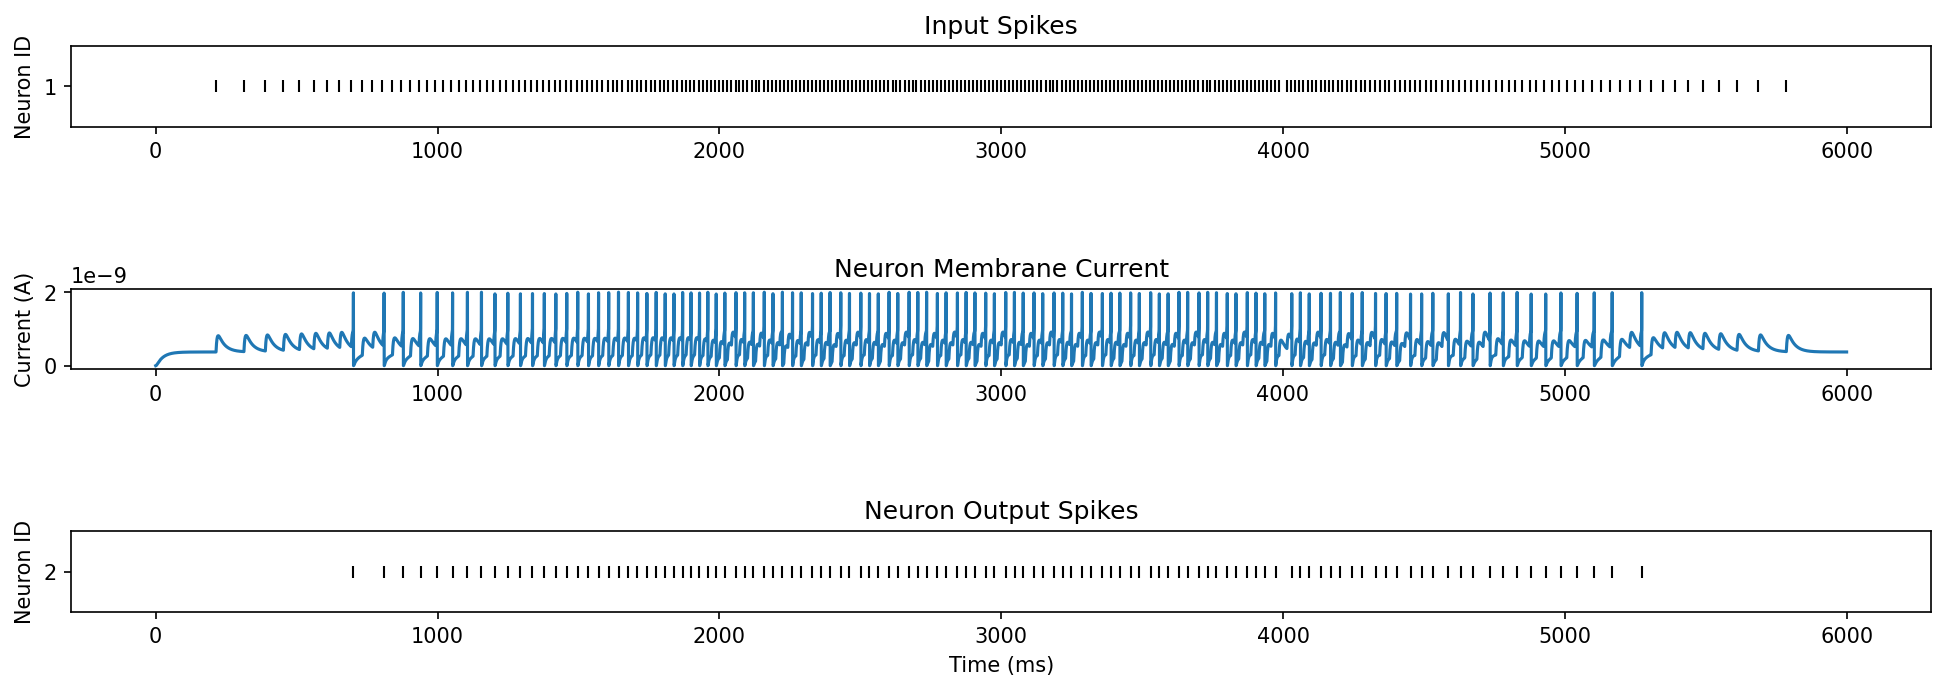

In [7]:
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(6000)
spike_placeholder[np.array(spikemon_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
# Imem = statemon_MNg[0].Isoma_mem[0]
# plt.plot(statemon_MNg[0].t/ms, Imem)
Imem = mon_neuron_state.Isoma_mem[0]
plt.plot(mon_neuron_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(6000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
# spike_placeholder[np.array(spikemon_MNg[0].t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')

plt.show()

Text(0.5, 0, 'Time (ms)')

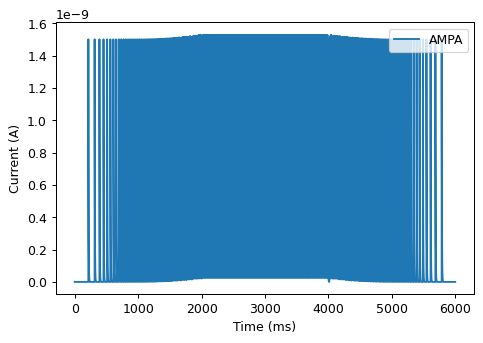

In [8]:
# Plotting
s = int(1*ms / defaultclock.dt)
tstart = 0 # ms 
tend   = 6000 # ms
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.Iampa[0][tstart*s:tend*s], linewidth=1.5)
plt.legend(['AMPA'])
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')